# Exploratory Data Analysis Module

In [2]:
import pandas as pd
import yfinance as yf
import plotly.express as px
import plotly.graph_objects as go
import seaborn as sn
import matplotlib.pyplot as plt
from matplotlib import pyplot
from statsmodels.graphics.tsaplots import plot_acf

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

In [99]:
class Stock_EDA:
    '''Stock Exploratory Data Analysis class for visualizing metrics
    and graphing various statistics. 
    
    Parameters
    ----------
    tickers: str or list of strings
        Tickers of the stocks to perform EDA on.
        
    start_date: str (yyyy-mm-dd)
        Start date of the stock history.
        
    end_date: str (yyyy-mm-dd)
        End date of the stock history.
        
    sampling_period: str, optional (default='1d')
        Sampling period of the pulled stock data. 
        Valid sampling periods: 1m,2m,5m,15m,30m,60m,90m,1h,1d,5d,1wk,1mo,3mo
        
    '''
    #
    def __init__(self, tickers, start_date, end_date, sampling_period='1d'):
        
        self.tickers = tickers
        self.start_date = start_date
        self.end_date = end_date
        self.sampling_period = sampling_period
        raw_data = yf.download(tickers, start=self.start_date, end=self.end_date, interval=self.sampling_period)
        self.data = raw_data.stack(1).reset_index().rename(columns = {'level_1':'Ticker'}).set_index('Date')
        
    def plot_adj_close(self, tickers='all'):
        
        """
        Plot the adjusted closing price time series for all of the
        stocks in the downloaded data or a subset of them.
        
        Parameters
        ----------
        tickers: string or list of strings
            The stocks to be plotted
            
        Returns
        -------
        plotly figure of the adjusted price of the time series. 
        
        """
        
        if tickers == 'all':
            fig = px.line(self.data, x = self.data.index, 
                          y = "Adj Close", 
                          title = "Historical Stock Price",
                         color = "Ticker")
            fig.show()
        else:
            fig = px.line(self.data[self.data['Ticker'].isin(tickers)], 
                         x = self.data[self.data['Ticker'].isin(tickers)].index,
                        y = "Adj Close",
                         title = "Historical Stock Price",
                         color = "Ticker")
            fig.update_layout(
                            xaxis_title="Time",
                            yaxis_title="Adj Close ($)"
            )
            fig.show()
            
    def plot_candlestick(self, ticker = None):
        
        if ticker is None:
            ticker = self.data['Tickers'].unique()[0]
        
        if isinstance(ticker, str) and self.data['Ticker'].str.contains(ticker).any():
            fig = go.Figure(data = [go.Candlestick(x = self.data[self.data['Ticker'] == ticker].index, 
                                       open = self.data[self.data['Ticker'] == ticker]['Open'],
                                      high = self.data[self.data['Ticker'] == ticker]['High'],
                                      low = self.data[self.data['Ticker'] == ticker]['Low'],
                                      close = self.data[self.data['Ticker'] == ticker]['Close'])])
            fig.update_layout(
                            title= ticker + " Historical Candlestick",
                            xaxis_title="Time",
                            yaxis_title="Price ($)"
            )
            fig.show()
        else:
            return print("Must provide existing single ticker as string")
        
    def plot_volume(self, ticker = None):
        
        if ticker is None:
            ticker = self.data['Tickers'].unique()[0]
        
        if isinstance(ticker, str) and self.data['Ticker'].str.contains(ticker).any():
            fig = px.bar(self.data, x= self.data[self.data['Ticker'] == ticker].index, 
                         y=self.data[self.data['Ticker'] == ticker]['Volume']
                       )
            fig.update_layout(
                            title= ticker + " Historical Volume",
                            xaxis_title="Time",
                            yaxis_title="Volume"
            )
            fig.show()
        else:
            return print("Must provide existing single ticker as string")
        
    def plot_one_period_returns(self, tickers = 'all'):
        
        if tickers == 'all':
            fig = px.line(self.data.pivot(columns='Ticker', values='Adj Close').pct_change().reset_index().melt(id_vars='Date', value_name='One-Period Returns').set_index('Date'),
                          x = self.data.pivot(columns='Ticker', values='Adj Close').pct_change().reset_index().melt(id_vars='Date', value_name='One-Period Returns').set_index('Date').index, 
                          y = "One-Period Returns", 
                          title = "Historical One-Period Returns",
                          color = "Ticker")
            fig.show()
        else:
            fig = px.line(self.data.pivot(columns='Ticker', values='Adj Close').pct_change().reset_index().melt(id_vars='Date', value_name='One-Period Returns').set_index('Date'),
                          x = self.data[self.data['Ticker'].isin(tickers)].pivot(columns='Ticker', values='Adj Close').pct_change().reset_index().melt(id_vars='Date', value_name='One-Period Returns').set_index('Date').index, 
                          y = "One-Period Returns", 
                          title = "Historical One-Period Returns",
                          color = "Ticker")
            fig.show()
    
    def plot_multi_period_returns(self, tickers = 'all', start = str(min(ex.data.index.date)), end = str(max(ex.data.index.date))):
        
        if tickers == 'all':
            # Pivot the dataframe so that each ticker's Adj Close is a column
            data_pivot = self.data.pivot(columns='Ticker', values='Adj Close')
            # filter the dataframe on user-specified start and end and take the difference of each row
            # w.r.t the start
            data_pivot_mpr = (data_pivot[(data_pivot.index >= start) & (data_pivot.index <= end)] - \
            data_pivot[(data_pivot.index >= start) & (data_pivot.index <= end)].iloc[0]) / \
            data_pivot[(data_pivot.index >= start) & (data_pivot.index <= end)].iloc[0]
            # melt to long format, with ticker column and adj close column
            data_pivot_mpr_plot = data_pivot_mpr.reset_index() \
                                                .melt(id_vars='Date', value_name='Multiperiod Returns') \
                                                .set_index('Date')
            
            fig = px.line(data_pivot_mpr_plot,
                          x = data_pivot_mpr_plot.index, 
                          y = "Multiperiod Returns", 
                          title = f"Historical Multiperiod Returns w.r.t {start}",
                          color = "Ticker")
            fig.show()
        else:
            data_pivot = self.data[self.data['Ticker'].isin(tickers)].pivot(columns='Ticker', values='Adj Close')
            
            data_pivot_mpr = (data_pivot[(data_pivot.index >= start) & (data_pivot.index <= end)] - \
            data_pivot[(data_pivot.index >= start) & (data_pivot.index <= end)].iloc[0]) / \
            data_pivot[(data_pivot.index >= start) & (data_pivot.index <= end)].iloc[0]
            
            data_pivot_mpr_plot = data_pivot_mpr.reset_index() \
                                                .melt(id_vars='Date', value_name='Multiperiod Returns') \
                                                .set_index('Date')
            
            fig = px.line(data_pivot_mpr_plot,
                          x = data_pivot_mpr_plot.index, 
                          y = "Multiperiod Returns", 
                          title = f"Historical Multiperiod Returns w.r.t {start}",
                          color = "Ticker")
            fig.show()

    def plot_pearson_correlations(self, tickers = 'all'):
        
        if tickers == 'all':
            corrMatrix = self.data.pivot(columns='Ticker', values='Adj Close').corr()
        else:
            corrMatrix = self.data[self.data['Ticker'].isin(tickers)].pivot( columns = 'Ticker', values = 'Adj Close').corr()
            
        fig, ax = plt.subplots(figsize=(15, 10))
        ax = sn.heatmap(
            corrMatrix, 
            vmin=-1, vmax=1, center=0,
            square=True,
            annot = True,
            cmap='coolwarm'
        )

        ax.set_xticklabels(
            ax.get_xticklabels(),
            rotation=45,
            horizontalalignment='right'
        )
        
    def plot_auto_correlations(self, ticker = None, returns = True):
        
        if ticker is None:
            ticker = self.data['Ticker'].unique()[0]
        
        if returns == True:
            plot_acf(self.data.pivot(columns='Ticker', values='Adj Close').pct_change()[ticker][1:])
            fig = pyplot.gcf()
            fig.set_size_inches(15, 7)
            plt.xlabel('Lags')
            plt.ylabel('Correlation')
            plt.title('Auto-Correlation of ' + ticker + ' Returns')
            pyplot.show()
        else:
            plot_acf(self.data['Adj Close'], alpha = .05)
            fig = pyplot.gcf()
            fig.set_size_inches(15, 7)
            plt.xlabel('Lags')
            plt.ylabel('Correlation')
            plt.title('Auto-Correlation of ' + ticker)
            pyplot.show()

### Instantiate an EDA object

In [100]:
ex = Stock_EDA(['EBAY', 'TSLA', 'FDX'], '2018-01-02', '2020-12-11', '1d')

[*********************100%***********************]  3 of 3 completed


In [102]:
#ex.data[ex.data['Ticker'] == 'EBAY'].loc['2018-01-02']

#(ex.data[(ex.data.index > '2018-01-02') & (ex.data['Ticker'] == 'EBAY')]['Adj Close'] - \
#ex.data[(ex.data.index > '2018-01-02') & (ex.data['Ticker'] == 'EBAY')]['Adj Close'][0]) / \
#ex.data[(ex.data.index > '2018-01-02') & (ex.data['Ticker'] == 'EBAY')]['Adj Close'][0]

ex.plot_multi_period_returns(tickers = ['EBAY','TSLA'], start = '2020-01-01')

#str(max(ex.data.index.date))

In [53]:
ex.data[(ex.data.index > '2018-01-02')][['Ticker','Adj Close']].sort_values(['Ticker','Date'])

ex.data.pivot(columns='Ticker', values='Adj Close').pct_change().reset_index().melt(id_vars='Date', value_name='Daily Returns').set_index('Date')

,Ticker,Daily Returns
Date,,
2018-01-02,EBAY,NaN
2018-01-03,EBAY,0.030478
2018-01-04,EBAY,-0.016573
2018-01-05,EBAY,0.029038
2018-01-08,EBAY,0.002771
2018-01-09,EBAY,-0.006784
2018-01-10,EBAY,-0.046294
2018-01-11,EBAY,0.002918
2018-01-12,EBAY,0.005554


In [98]:
import dateutil.parser

tickers = ['EBAY','TSLA']

data_pivot = ex.data[ex.data['Ticker'].isin(tickers)].pivot(columns='Ticker', values='Adj Close')
data_pivot_mpr = (data_pivot[(data_pivot.index >= '2018-01-04') & (data_pivot.index <= '2020-12-10')] - \
data_pivot[(data_pivot.index >= '2018-01-04') & (data_pivot.index <= '2020-12-10')].iloc[0]) / \
data_pivot[(data_pivot.index >= '2018-01-04') & (data_pivot.index <= '2020-12-10')].iloc[0]

#data_pivot_mpr_plot = data_pivot_mpr.reset_index().melt(id_vars='Date', value_name='Multiperiod Returns').set_index('Date')

data_pivot_mpr_plot = data_pivot_mpr.reset_index() \
            .melt(id_vars='Date', value_name='Multiperiod Returns') \
            .set_index('Date')

fig = px.line(data_pivot_mpr_plot,
                          x = data_pivot_mpr_plot.index, 
                          y = "Multiperiod Returns", 
                          title = "Historical Multiperiod Returns",
                          color = "Ticker")
fig.show()
#data_pivot[(data_pivot.index > dateutil.parser.parse('2018-01-04'))] 

In [71]:
data_pivot

Ticker,EBAY,FDX,TSLA
Date,,,
2018-01-02,36.734085,246.582428,64.106003
2018-01-03,37.853672,249.664749,63.450001
2018-01-04,37.226311,253.551086,62.924000
2018-01-05,38.307301,254.546661,63.316002
2018-01-08,38.413464,257.169403,67.281998
2018-01-09,38.152866,256.298279,66.737999
2018-01-10,36.386623,256.547211,66.959999
2018-01-11,36.492790,259.591125,67.589996
2018-01-12,36.695473,260.222992,67.244003


In [58]:
ex.plot_adj_close()

In [6]:
ex.plot_candlestick(ticker = 'FDX')

In [7]:
ex.plot_volume(ticker = 'FDX')

In [8]:
ex.plot_oneperiod_returns()

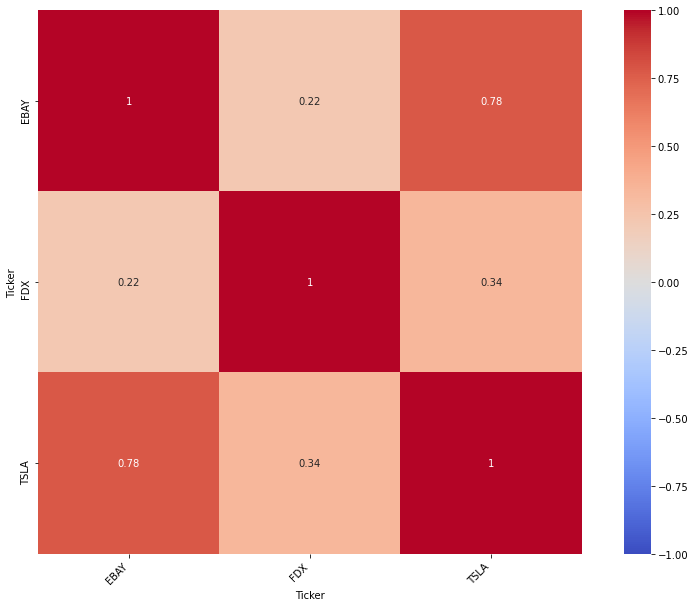

In [9]:
ex.plot_pearson_correlations()

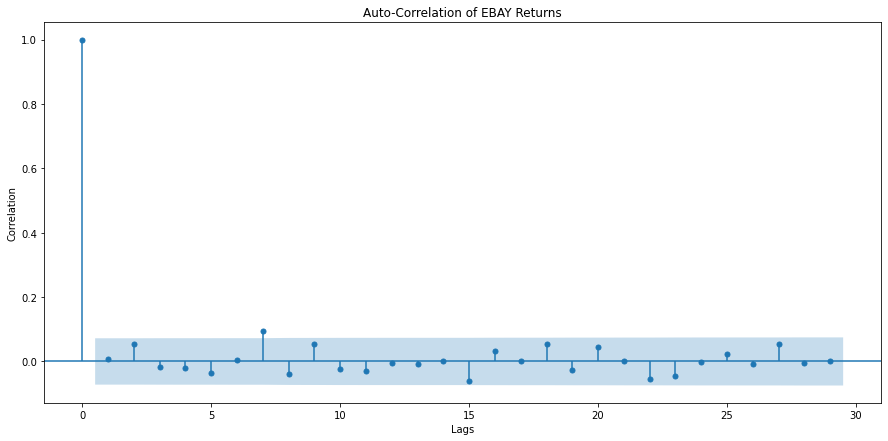

In [10]:
ex.plot_auto_correlations(ticker = 'EBAY')